<a href="https://colab.research.google.com/github/sedaoturak/vae_cahn-hilliard/blob/main/VAE_Cahn_Hillard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import os
try:
	from google.colab import drive
	IN_COLAB = True
	drive.mount('/content/drive')
	PATH = '/content/drive/MyDrive/Colab Notebooks/' # change this with your drive's path
	except:
	IN_COLAB = False
	PATH = os.getcwd()[:-9]

Mounted at /content/drive


# Load data

In [2]:
# define the directory to dataset (the folder having the bitmap images and their strain energy values in text files
with open(PATH+'toy_datasets/Mechanical_MNIST/Case1_input_patterns_64_x_64.txt', 'r') as f:
  g = np.loadtxt(f)
with open(PATH+'toy_datasets/Mechanical_MNIST/Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

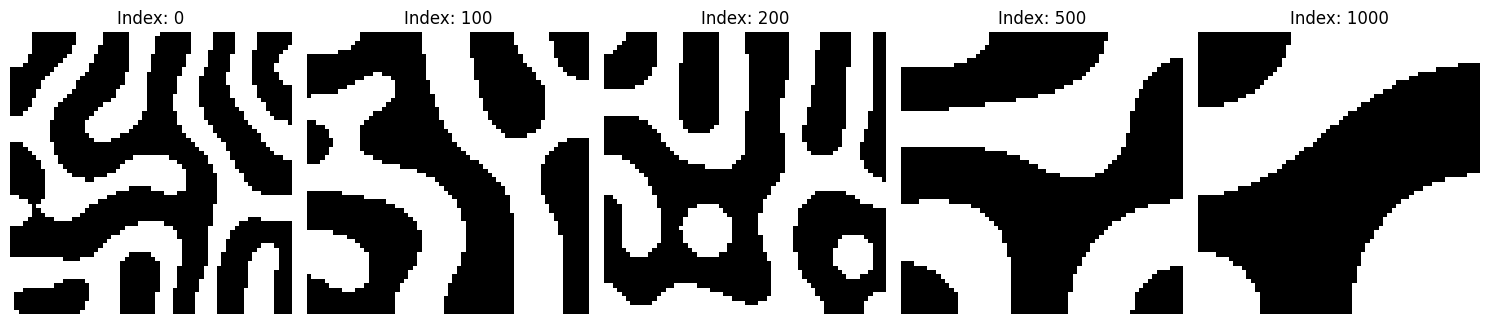

In [3]:
# visualize an image from dataset
img = g.reshape(37523,64,64) # reshape image dataset so that you'll get (number of images, first dimension, second dimension)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate([0,100, 200, 500, 1000]): #random indices of five images
    axes[i].imshow(img[idx, :, :], interpolation='nearest', cmap='binary')
    axes[i].set_title(f"Index: {idx}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Preprocessing

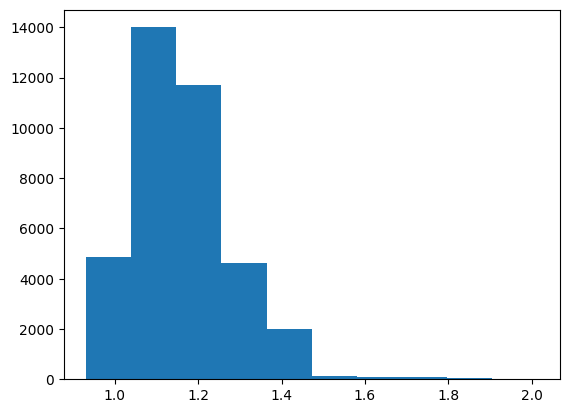

In [4]:
# visualize the distribution of the output (energy) values
# maximum energy (at the last index) is considered

fig, ax = plt.subplots()
ax.hist(e[:,-1])
plt.show()

In [5]:
# apply different preprocessing on the strain energy values to compare
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_scaled = scaler.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation
pt = PowerTransformer()
e_power = pt.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation + normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_power_scaled = scaler.fit_transform(e_power)

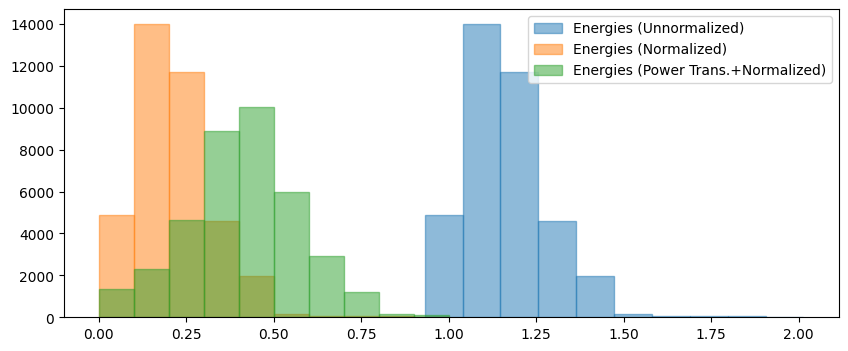

In [6]:
fig, axs = plt.subplots(figsize=(10,4))

axs.hist(e[:,-1], label=f'Energies (Unnormalized)', alpha=0.5, edgecolor='tab:blue', linewidth=1)
axs.hist(e_scaled, label=f'Energies (Normalized)', alpha=0.5, edgecolor='tab:orange', linewidth=1)
# axs.hist(e_power, label=f'Energies (Power Trans.)', alpha=0.5, edgecolor='tab:red', linewidth=1)
axs.hist(e_power_scaled, label=f'Energies (Power Trans.+Normalized)', alpha=0.5, edgecolor='tab:green', linewidth=1)
axs.legend()
plt.show()

In [7]:
# create Dataset class to define the dataset oject

class CustomDataset(Dataset):
  def __init__(self, imgs, labels, transform):
    self.labels = labels
    self.imgs = imgs
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    if self.labels is None:
      x = self.imgs[index]
      x = self.transform(x)
      return x
    else:
      x = self.imgs[index]
      x = self.transform(x)
      y = self.labels[index]
    return x, y

images = g.reshape((37523,64,64))
energies = e_power_scaled.ravel()

# unpack to batch, width, height
b, w, h, = [*images.shape]
print(images.shape)

# add a channel dimension
images_wb = np.repeat(images[..., np.newaxis], 1, -1)
print(images_wb.shape)

# prepare images for neural network with the shape of (Batch, Channels, Width, Height)
images_wb = images_wb.reshape(b, 1, w, h)
print(images_wb.shape)

(37523, 64, 64)
(37523, 64, 64, 1)
(37523, 1, 64, 64)


In [8]:
# apply transformations on images if necessary
transform = transforms.Compose([
      # transforms.Resize((32, 32)),
        ])

# define the data
normalized_images = images_wb
data = torch.tensor(normalized_images, dtype=torch.float32)
target = torch.tensor(energies, dtype=torch.float32).reshape(-1,1)

if __name__ == "__main__":
  dataset = CustomDataset(data, target, transform)

In [9]:
# train-test split
train_set_size = int(len(dataset)*0.8)
val_set_size = len(dataset) - train_set_size

trainset, valset  = random_split(dataset, [train_set_size, val_set_size])
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers= 2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers= 2)

# Model

In [10]:
# Define the model

class ConvVAE(nn.Module):
    def __init__(self, image_channels=1, init_channels=16, kernel_size=4, latent_dim=16):
        super(ConvVAE, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels*4, kernel_size=kernel_size,
                              stride=2, padding=1)
        self.enc2 = nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size,
                              stride=2, padding=1)
        self.enc3 = nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size,
                              stride=2, padding=1)
        self.enc4 = nn.Conv2d(in_channels=init_channels*8, out_channels=64, kernel_size=kernel_size,
                              stride=2, padding=0)
        self.dropout = nn.Dropout(0.25)

        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        # decoder
        self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
                                       stride=1, padding=0)
        self.dec2 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size,
                                       stride=2, padding=1)
        self.dec3 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
                                       stride=2, padding=1)
        self.dec4 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
                                       stride=2, padding=1)
        self.dec5 = nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
                                       stride=2, padding=1)
    def encoder(self, x):
        x = F.relu(self.enc1(x))
        x = self.dropout(x)
        x = F.relu(self.enc2(x))
        # x = self.dropout(x)
        x = F.relu(self.enc3(x))
        # x = self.dropout(x)
        x = F.relu(self.enc4(x))
        # x = self.dropout(x)
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        return hidden

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)
        sample = mu + (eps * std) # sampling
        return sample

    def decoder(self,z):
        x = F.relu(self.dec1(z))
        # x = self.dropout(x)
        x = F.relu(self.dec2(x))
        # x = self.dropout(x)
        x = F.relu(self.dec3(x))
        # x = self.dropout(x)
        x = F.relu(self.dec4(x))
        x = self.dropout(x)
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction

    def forward(self, x):
        hidden = self.encoder(x)
        # get 'mu' and 'log_var'
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        x = self.fc2(z)
        x = x.view(-1, 64, 1, 1)
        out = self.decoder(x)
        return z, mu, log_var, out

# Training

In [11]:
# define the model object and other training parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE(image_channels=1, init_channels=16, kernel_size=4, latent_dim=16).to(device)
# set the optimizerparameters
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')

torch.backends.cudnn.benchmark = True

def final_loss(mse_loss, beta, mu, logvar):
    BCE = mse_loss
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    return BCE + beta*KLD

def train(dataloader, dataset, beta):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, (data,target) in tqdm(enumerate(dataloader)):
        counter += 1
        data = data.to(device)
        optimizer.zero_grad(set_to_none=True)

        z, mu, logvar, out = model(data)
        bce_loss = criterion(out, data)
        loss = final_loss(bce_loss, beta, mu, logvar)

        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return z, train_loss

def validate(dataloader, dataset, beta):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, (data,target) in tqdm(enumerate(dataloader)):
            counter += 1
            data = data.to(device)
            z, mu, logvar, out = model(data)
            bce_loss = criterion(out, data)
            loss = final_loss(bce_loss, beta, mu, logvar)
            running_loss += loss.item()

    val_loss = running_loss / counter
    return z, val_loss

In [12]:
epochs = 100

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    # beta annealing
    if epoch<30:
      beta=0
    else:
      beta=1e-4

    ztrain, train_epoch_loss = train(trainloader, trainset, beta)
    zval, valid_epoch_loss = validate(valloader, valset, beta)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}, Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 100


470it [00:09, 50.82it/s]
118it [00:00, 149.46it/s]

Train Loss: 0.1991, Val Loss: 0.1419
Epoch 2 of 100



470it [00:06, 71.72it/s]
118it [00:00, 132.30it/s]

Train Loss: 0.1109, Val Loss: 0.1063
Epoch 3 of 100



470it [00:06, 68.87it/s]
118it [00:00, 160.60it/s]

Train Loss: 0.0865, Val Loss: 0.0918
Epoch 4 of 100



470it [00:06, 68.39it/s]
118it [00:00, 131.24it/s]

Train Loss: 0.0739, Val Loss: 0.0742
Epoch 5 of 100



470it [00:07, 64.54it/s]
118it [00:00, 162.06it/s]

Train Loss: 0.0655, Val Loss: 0.0695
Epoch 6 of 100



470it [00:07, 66.16it/s]
118it [00:00, 158.39it/s]

Train Loss: 0.0593, Val Loss: 0.0635
Epoch 7 of 100



470it [00:09, 49.07it/s]
118it [00:01, 78.47it/s] 

Train Loss: 0.0547, Val Loss: 0.0622
Epoch 8 of 100



470it [00:08, 53.76it/s]
118it [00:00, 145.72it/s]

Train Loss: 0.0505, Val Loss: 0.0535
Epoch 9 of 100



470it [00:07, 66.71it/s]
118it [00:00, 161.85it/s]

Train Loss: 0.0475, Val Loss: 0.0532
Epoch 10 of 100



470it [00:06, 67.32it/s]
118it [00:00, 124.43it/s]

Train Loss: 0.0449, Val Loss: 0.0499
Epoch 11 of 100



470it [00:06, 70.39it/s]
118it [00:00, 160.74it/s]

Train Loss: 0.0428, Val Loss: 0.0496
Epoch 12 of 100



470it [00:06, 67.15it/s]
118it [00:00, 157.85it/s]

Train Loss: 0.0414, Val Loss: 0.0456
Epoch 13 of 100



470it [00:06, 70.54it/s]
118it [00:00, 163.80it/s]

Train Loss: 0.0393, Val Loss: 0.0493
Epoch 14 of 100



470it [00:07, 67.07it/s]
118it [00:00, 159.60it/s]

Train Loss: 0.0386, Val Loss: 0.0491
Epoch 15 of 100



470it [00:06, 68.77it/s]
118it [00:00, 120.62it/s]

Train Loss: 0.0376, Val Loss: 0.0421
Epoch 16 of 100



470it [00:06, 68.93it/s]
118it [00:00, 160.31it/s]

Train Loss: 0.0360, Val Loss: 0.0424
Epoch 17 of 100



470it [00:06, 67.39it/s]
118it [00:00, 160.67it/s]

Train Loss: 0.0352, Val Loss: 0.0421
Epoch 18 of 100



470it [00:07, 60.92it/s]
118it [00:00, 137.24it/s]

Train Loss: 0.0341, Val Loss: 0.0399
Epoch 19 of 100



470it [00:06, 67.85it/s]
118it [00:00, 161.35it/s]

Train Loss: 0.0335, Val Loss: 0.0433
Epoch 20 of 100



470it [00:08, 53.40it/s]
118it [00:00, 159.66it/s]

Train Loss: 0.0331, Val Loss: 0.0386
Epoch 21 of 100



470it [00:06, 70.35it/s]
118it [00:00, 159.51it/s]

Train Loss: 0.0321, Val Loss: 0.0416
Epoch 22 of 100



470it [00:06, 67.71it/s]
118it [00:00, 162.19it/s]

Train Loss: 0.0323, Val Loss: 0.0382
Epoch 23 of 100



470it [00:06, 69.89it/s]
118it [00:01, 116.61it/s]

Train Loss: 0.0312, Val Loss: 0.0357
Epoch 24 of 100



470it [00:06, 68.09it/s]
118it [00:00, 158.92it/s]

Train Loss: 0.0309, Val Loss: 0.0384
Epoch 25 of 100



470it [00:06, 67.81it/s]
118it [00:00, 149.20it/s]

Train Loss: 0.0303, Val Loss: 0.0371
Epoch 26 of 100



470it [00:06, 70.51it/s]
118it [00:00, 160.99it/s]

Train Loss: 0.0299, Val Loss: 0.0410
Epoch 27 of 100



470it [00:07, 67.02it/s]
118it [00:00, 162.83it/s]

Train Loss: 0.0300, Val Loss: 0.0350
Epoch 28 of 100



470it [00:06, 70.60it/s]
118it [00:00, 144.91it/s]

Train Loss: 0.0289, Val Loss: 0.0346
Epoch 29 of 100



470it [00:06, 67.52it/s]
118it [00:00, 160.71it/s]

Train Loss: 0.0285, Val Loss: 0.0338
Epoch 30 of 100



470it [00:06, 68.05it/s]
118it [00:00, 132.31it/s]

Train Loss: 0.0282, Val Loss: 0.0345
Epoch 31 of 100



470it [00:06, 70.05it/s]
118it [00:00, 161.18it/s]

Train Loss: 0.0361, Val Loss: 0.0550
Epoch 32 of 100



470it [00:06, 67.30it/s]
118it [00:00, 159.83it/s]

Train Loss: 0.0358, Val Loss: 0.0419
Epoch 33 of 100



470it [00:06, 70.60it/s]
118it [00:00, 160.90it/s]

Train Loss: 0.0347, Val Loss: 0.0403
Epoch 34 of 100



470it [00:06, 67.15it/s]
118it [00:00, 163.38it/s]

Train Loss: 0.0342, Val Loss: 0.0402
Epoch 35 of 100



470it [00:06, 68.32it/s]
118it [00:00, 124.22it/s]

Train Loss: 0.0340, Val Loss: 0.0410
Epoch 36 of 100



470it [00:06, 70.01it/s]
118it [00:00, 158.96it/s]

Train Loss: 0.0340, Val Loss: 0.0411
Epoch 37 of 100



470it [00:06, 67.69it/s]
118it [00:00, 161.02it/s]

Train Loss: 0.0337, Val Loss: 0.0473
Epoch 38 of 100



470it [00:06, 70.44it/s]
118it [00:00, 161.72it/s]

Train Loss: 0.0342, Val Loss: 0.0383
Epoch 39 of 100



470it [00:06, 67.55it/s]
118it [00:00, 159.82it/s]

Train Loss: 0.0331, Val Loss: 0.0387
Epoch 40 of 100



470it [00:06, 68.81it/s]
118it [00:00, 124.92it/s]

Train Loss: 0.0329, Val Loss: 0.0395
Epoch 41 of 100



470it [00:06, 69.35it/s]
118it [00:00, 160.02it/s]

Train Loss: 0.0328, Val Loss: 0.0401
Epoch 42 of 100



470it [00:06, 67.38it/s]
118it [00:00, 159.95it/s]

Train Loss: 0.0329, Val Loss: 0.0401
Epoch 43 of 100



470it [00:06, 70.52it/s]
118it [00:00, 159.61it/s]

Train Loss: 0.0326, Val Loss: 0.0392
Epoch 44 of 100



470it [00:07, 67.09it/s]
118it [00:00, 157.15it/s]

Train Loss: 0.0322, Val Loss: 0.0386
Epoch 45 of 100



470it [00:06, 69.45it/s]
118it [00:00, 121.57it/s]

Train Loss: 0.0322, Val Loss: 0.0400
Epoch 46 of 100



470it [00:06, 69.07it/s]
118it [00:00, 161.38it/s]

Train Loss: 0.0318, Val Loss: 0.0387
Epoch 47 of 100



470it [00:06, 67.28it/s]
118it [00:00, 160.44it/s]

Train Loss: 0.0317, Val Loss: 0.0406
Epoch 48 of 100



470it [00:06, 70.55it/s]
118it [00:00, 161.86it/s]

Train Loss: 0.0322, Val Loss: 0.0409
Epoch 49 of 100



470it [00:06, 67.53it/s]
118it [00:00, 162.55it/s]

Train Loss: 0.0317, Val Loss: 0.0379
Epoch 50 of 100



470it [00:06, 69.62it/s]
118it [00:00, 123.63it/s]

Train Loss: 0.0313, Val Loss: 0.0367
Epoch 51 of 100



470it [00:06, 68.40it/s]
118it [00:00, 163.80it/s]

Train Loss: 0.0311, Val Loss: 0.0369
Epoch 52 of 100



470it [00:06, 67.61it/s]
118it [00:00, 161.22it/s]

Train Loss: 0.0311, Val Loss: 0.0381
Epoch 53 of 100



470it [00:06, 70.64it/s]
118it [00:00, 160.83it/s]

Train Loss: 0.0310, Val Loss: 0.0371
Epoch 54 of 100



470it [00:06, 67.66it/s]
118it [00:00, 161.96it/s]

Train Loss: 0.0306, Val Loss: 0.0371
Epoch 55 of 100



470it [00:06, 70.56it/s]
118it [00:00, 128.38it/s]

Train Loss: 0.0307, Val Loss: 0.0358
Epoch 56 of 100



470it [00:06, 68.00it/s]
118it [00:00, 160.82it/s]

Train Loss: 0.0303, Val Loss: 0.0356
Epoch 57 of 100



470it [00:06, 68.28it/s]
118it [00:00, 138.37it/s]

Train Loss: 0.0303, Val Loss: 0.0382
Epoch 58 of 100



470it [00:06, 70.76it/s]
118it [00:00, 161.65it/s]

Train Loss: 0.0304, Val Loss: 0.0359
Epoch 59 of 100



470it [00:06, 67.71it/s]
118it [00:00, 162.86it/s]

Train Loss: 0.0300, Val Loss: 0.0359
Epoch 60 of 100



470it [00:06, 70.57it/s]
118it [00:00, 153.33it/s]

Train Loss: 0.0300, Val Loss: 0.0366
Epoch 61 of 100



470it [00:06, 67.65it/s]
118it [00:00, 153.98it/s]

Train Loss: 0.0299, Val Loss: 0.0359
Epoch 62 of 100



470it [00:06, 68.96it/s]
118it [00:00, 126.42it/s]

Train Loss: 0.0299, Val Loss: 0.0362
Epoch 63 of 100



470it [00:06, 70.04it/s]
118it [00:00, 160.75it/s]

Train Loss: 0.0298, Val Loss: 0.0355
Epoch 64 of 100



470it [00:06, 67.98it/s]
118it [00:00, 160.46it/s]

Train Loss: 0.0297, Val Loss: 0.0358
Epoch 65 of 100



470it [00:06, 70.42it/s]
118it [00:00, 163.34it/s]

Train Loss: 0.0297, Val Loss: 0.0372
Epoch 66 of 100



470it [00:06, 67.39it/s]
118it [00:00, 162.07it/s]

Train Loss: 0.0297, Val Loss: 0.0381
Epoch 67 of 100



470it [00:06, 69.44it/s]
118it [00:00, 119.47it/s]

Train Loss: 0.0300, Val Loss: 0.0369
Epoch 68 of 100



470it [00:06, 69.38it/s]
118it [00:00, 161.53it/s]

Train Loss: 0.0294, Val Loss: 0.0383
Epoch 69 of 100



470it [00:06, 67.29it/s]
118it [00:00, 161.96it/s]

Train Loss: 0.0296, Val Loss: 0.0357
Epoch 70 of 100



470it [00:06, 70.69it/s]
118it [00:00, 161.50it/s]

Train Loss: 0.0291, Val Loss: 0.0349
Epoch 71 of 100



470it [00:06, 67.31it/s]
118it [00:00, 161.55it/s]

Train Loss: 0.0289, Val Loss: 0.0352
Epoch 72 of 100



470it [00:06, 69.85it/s]
118it [00:00, 124.74it/s]

Train Loss: 0.0289, Val Loss: 0.0357
Epoch 73 of 100



470it [00:06, 68.85it/s]
118it [00:00, 160.69it/s]

Train Loss: 0.0291, Val Loss: 0.0348
Epoch 74 of 100



470it [00:06, 67.75it/s]
118it [00:00, 159.57it/s]

Train Loss: 0.0288, Val Loss: 0.0346
Epoch 75 of 100



470it [00:06, 70.62it/s]
118it [00:00, 158.52it/s]

Train Loss: 0.0290, Val Loss: 0.0347
Epoch 76 of 100



470it [00:06, 67.64it/s]
118it [00:00, 162.17it/s]

Train Loss: 0.0288, Val Loss: 0.0382
Epoch 77 of 100



470it [00:06, 70.70it/s]
118it [00:00, 128.53it/s]

Train Loss: 0.0289, Val Loss: 0.0344
Epoch 78 of 100



470it [00:06, 68.28it/s]
118it [00:00, 157.75it/s]

Train Loss: 0.0284, Val Loss: 0.0340
Epoch 79 of 100



470it [00:06, 68.10it/s]
118it [00:00, 138.76it/s]

Train Loss: 0.0285, Val Loss: 0.0355
Epoch 80 of 100



470it [00:06, 70.47it/s]
118it [00:00, 164.66it/s]

Train Loss: 0.0285, Val Loss: 0.0360
Epoch 81 of 100



470it [00:06, 67.77it/s]
118it [00:00, 160.13it/s]

Train Loss: 0.0286, Val Loss: 0.0352
Epoch 82 of 100



470it [00:06, 70.79it/s]
118it [00:00, 160.96it/s]

Train Loss: 0.0283, Val Loss: 0.0340
Epoch 83 of 100



470it [00:06, 67.44it/s]
118it [00:00, 160.95it/s]

Train Loss: 0.0281, Val Loss: 0.0346
Epoch 84 of 100



470it [00:06, 69.00it/s]
118it [00:00, 127.02it/s]

Train Loss: 0.0283, Val Loss: 0.0351
Epoch 85 of 100



470it [00:06, 69.02it/s]
118it [00:00, 158.23it/s]

Train Loss: 0.0282, Val Loss: 0.0343
Epoch 86 of 100



470it [00:06, 67.42it/s]
118it [00:00, 161.48it/s]

Train Loss: 0.0281, Val Loss: 0.0343
Epoch 87 of 100



470it [00:06, 70.58it/s]
118it [00:00, 161.87it/s]

Train Loss: 0.0280, Val Loss: 0.0363
Epoch 88 of 100



470it [00:06, 67.50it/s]
118it [00:00, 160.24it/s]

Train Loss: 0.0284, Val Loss: 0.0332
Epoch 89 of 100



470it [00:06, 69.30it/s]
118it [00:00, 124.36it/s]

Train Loss: 0.0278, Val Loss: 0.0338
Epoch 90 of 100



470it [00:06, 69.20it/s]
118it [00:00, 160.70it/s]

Train Loss: 0.0279, Val Loss: 0.0349
Epoch 91 of 100



470it [00:06, 67.91it/s]
118it [00:00, 161.25it/s]

Train Loss: 0.0280, Val Loss: 0.0343
Epoch 92 of 100



470it [00:06, 70.50it/s]
118it [00:00, 162.78it/s]

Train Loss: 0.0278, Val Loss: 0.0346
Epoch 93 of 100



470it [00:06, 67.27it/s]
118it [00:00, 162.65it/s]

Train Loss: 0.0278, Val Loss: 0.0355
Epoch 94 of 100



470it [00:06, 69.96it/s]
118it [00:00, 122.76it/s]

Train Loss: 0.0277, Val Loss: 0.0350
Epoch 95 of 100



470it [00:06, 68.36it/s]
118it [00:00, 161.87it/s]

Train Loss: 0.0277, Val Loss: 0.0331
Epoch 96 of 100



470it [00:06, 67.96it/s]
118it [00:00, 156.86it/s]

Train Loss: 0.0275, Val Loss: 0.0338
Epoch 97 of 100



470it [00:06, 70.47it/s]
118it [00:00, 161.40it/s]

Train Loss: 0.0277, Val Loss: 0.0371
Epoch 98 of 100



470it [00:06, 67.84it/s]
118it [00:00, 160.45it/s]

Train Loss: 0.0279, Val Loss: 0.0335
Epoch 99 of 100



470it [00:06, 70.54it/s]
118it [00:00, 139.14it/s]

Train Loss: 0.0274, Val Loss: 0.0344
Epoch 100 of 100



470it [00:06, 68.07it/s]
118it [00:00, 161.59it/s]

Train Loss: 0.0275, Val Loss: 0.0346


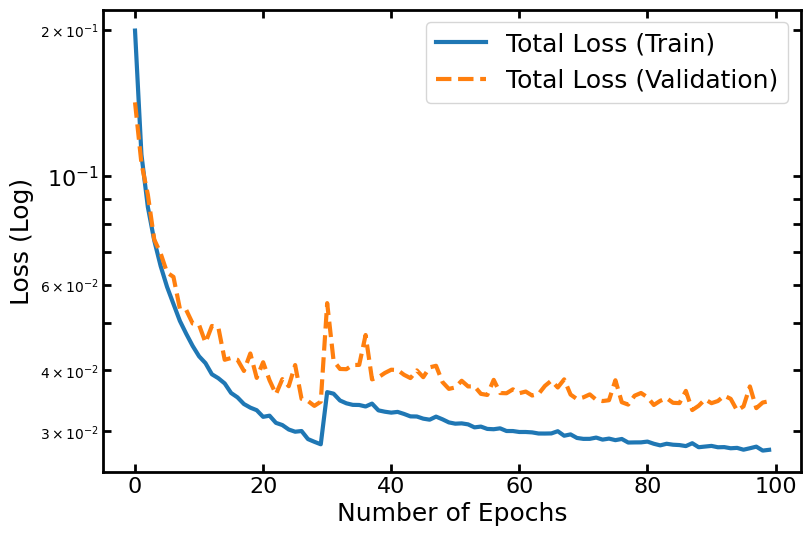

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
font_size, ticklabel_size = 18, 16

ax.plot(train_loss, '-', label='Total Loss (Train)', linewidth=3)
ax.plot(valid_loss,'--', label='Total Loss (Validation)', linewidth=3)

ax.set_ylabel('Loss (Log)', fontsize=font_size)
ax.set_xlabel('Number of Epochs', fontsize=font_size)
ax.set_yscale('log', base=10)

ax.xaxis.set_tick_params(width=2, length=8, labelsize=ticklabel_size)
ax.yaxis.set_tick_params(width=2, length=5, labelsize=ticklabel_size)
ax.tick_params(which='both', width=2, length=6, top=True, right=True, direction='in')
plt.setp(ax.spines.values(), linewidth=2)
ax.legend(fontsize=font_size)
plt.show()

In [ ]:
# save model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
torch.save(model, os.path.join(PATH, f'mech_MNIST_entire.pt'))

# model_scripted = torch.jit.script(model.cpu())
# model_scripted.save(os.path.join(PATH, f'mech_MNIST_scripted.pt'))

In [ ]:
# load trained model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
model = torch.load(os.path.join(PATH, f'mech_MNIST_vae_entire.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ConvVAE(
  (enc1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc4): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=64, bias=True)
  (dec1): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (dec2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec5): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=

# Reconstructed Images

In [17]:
original_images = []
reconstructed_images = []
z_train = np.zeros((0,16))
idx_train = []
strain_energy = np.zeros((0,1))
for i, (d,t) in tqdm(enumerate(trainloader)):
  d = d.to(device)
  z, _, _, out = model(d)
  original_images.append(d.cpu().detach().numpy())
  reconstructed_images.append(out.cpu().detach().numpy())
  z_train = np.vstack([z_train,z.cpu().detach().numpy()])
  strain_energy = np.vstack([strain_energy, t.cpu().detach().numpy()])
strain_energy = strain_energy.ravel()

470it [00:07, 65.73it/s]


Text(-10, 52, 'Reconstruction')

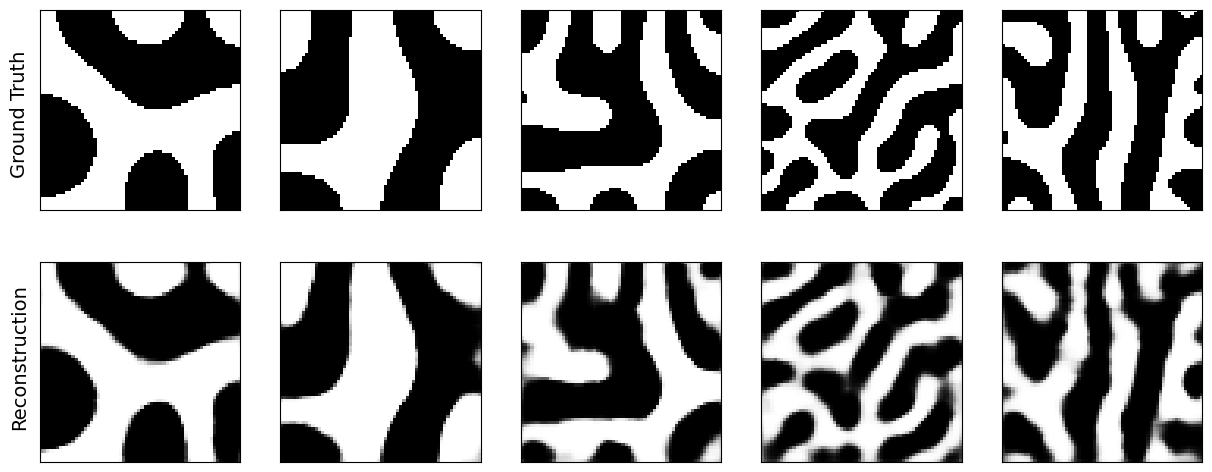

In [18]:
f, axs = plt.subplots(2,5, figsize=(15,6))
for i, ind in enumerate(np.random.randint(0,64,5)):
  axs[0,i].imshow(original_images[0].reshape(64,64,64)[ind,:,:], interpolation='nearest', cmap='binary')
  axs[0,i].axes.xaxis.set_visible(False)
  axs[0,i].axes.yaxis.set_visible(False)
  axs[1,i].imshow(reconstructed_images[0].reshape(64,64,64)[ind,:,:], interpolation='nearest', cmap='binary')
  axs[1,i].axes.xaxis.set_visible(False)
  axs[1,i].axes.yaxis.set_visible(False)

axs[0,0].text(-10, 52, 'Ground Truth', fontsize=14, rotation=90)
axs[1,0].text(-10, 52, 'Reconstruction', fontsize=14, rotation=90)

In [ ]:
import copy
train_loader_inds = copy.deepcopy(trainloader.dataset.indices)
train_loader_inds.sort()
chosen_indices = [trainloader.dataset.indices.index(geo) for geo in train_loader_inds[:37]]
chosen_indices

In [ ]:
# The indices of chosen microsturcture set in wholedataset
# to be used in vector arithmetics in latent space
ind_in_whole = [trainloader.dataset.indices.index(cho) for cho in train_loader_inds[:37]]
ind_in_whole

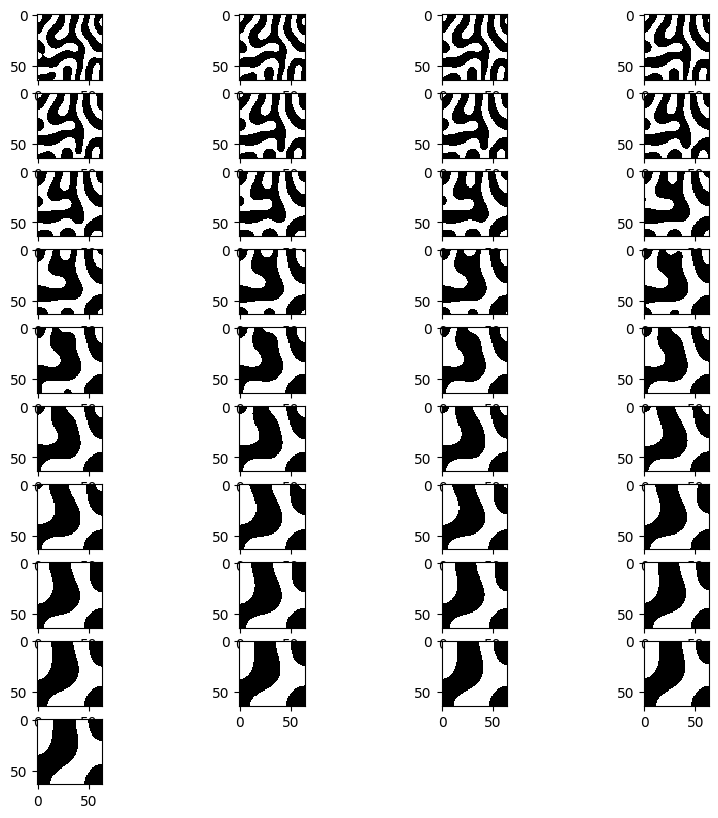

In [21]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i, ind in enumerate(chosen_indices):
    plt.subplot(10,4,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(g[train_loader_inds[i]].reshape(64,64), interpolation='nearest', cmap='binary')
    # print(ind)
plt.show()

# Latent Space

### PCA

In [22]:
# decrease the dimensionality of latent space from 16 to 2 to visualize
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_projected = pca.fit_transform(z_train)

z_train_labels = [e[indx,6] for indx in trainset.indices]

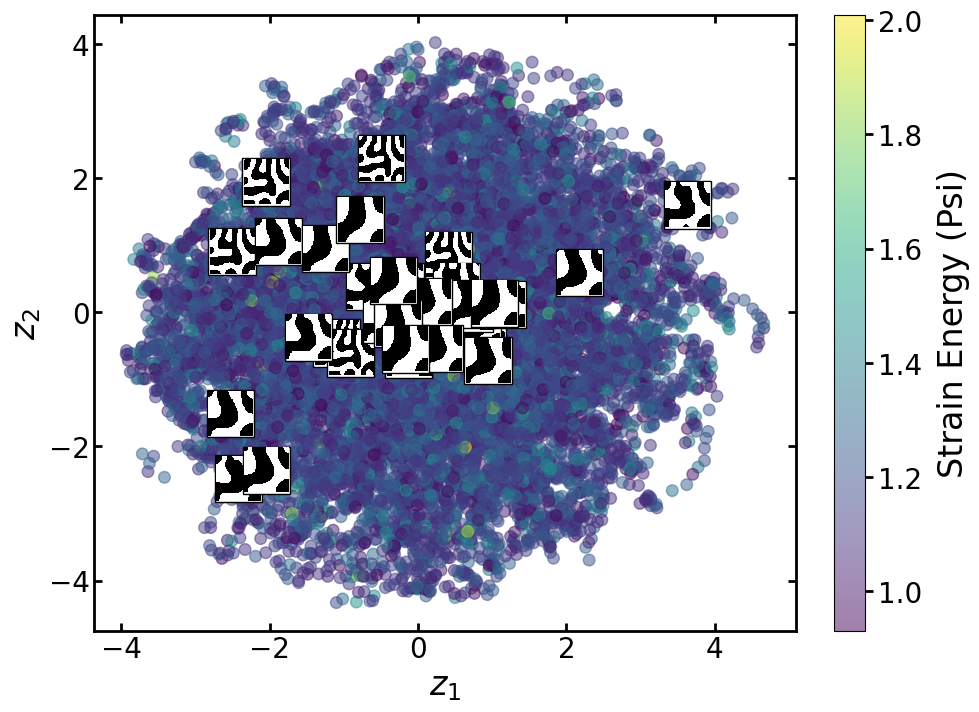

In [26]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
z = z_projected

fig, ax = plt.subplots(figsize=(10, 8))

font_size, ticklabel_size = 24, 20

sc = ax.scatter(*z.T, s=70, c=z_train_labels, cmap='viridis', alpha=0.5)

for i, ind in enumerate(ind_in_whole):
  # Define a 1st position to annotate (display it with a marker)
  xy = (z[ind,0], z[ind,1])

  # Annotate the 2nd position with an image (a generated array of pixels)
  arr = g[train_loader_inds[i]].reshape(64,64)
  im = OffsetImage(arr, norm=plt.Normalize(0,1), interpolation='nearest', cmap='binary', zoom=0.5)
  im.image.axes = ax

  ab = AnnotationBbox(im, xy,
                      xycoords='data',
                      boxcoords="offset points",
                      pad=0.1)
  ax.add_artist(ab)


ax.set_xlabel("$z_{1}$", fontsize=font_size)
ax.set_ylabel("$z_{2}$", fontsize=font_size)

plt.setp(ax.spines.values(), linewidth=2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.tick_params(direction='in', length=6, labelsize=ticklabel_size,top=True, right=True)

cbar = plt.colorbar(sc,fraction=0.045, pad=0.05)
cbar.set_label(label='Strain Energy (Psi)', labelpad=10, size=font_size)
cbar.ax.tick_params(length=6, width=2,labelsize=ticklabel_size)

In [28]:
import plotly.graph_objects as go

z = z_projected

fig = go.Figure(data=[go.Scatter(
                                  x = z[:,0],
                                  y = z[:,1],
                                  mode = 'markers',
                                  marker = dict(color= z_train_labels,
                                                colorscale='Viridis',
                                                size=12,
                                                opacity=0.5,
                                                colorbar=dict(thickness=12)))
])
fig.update_layout(height=500, width=600, showlegend=False,
                  margin=dict(l=70,r=50,b=70,t=50),
                  xaxis_title="$z_{1}$",
                  yaxis_title="$z_{2}$",
                       font=dict(
                           size=14
                           )
                  )
fig.show()